In [9]:
!pip install pandas numpy scikit-learn statsmodels

In [30]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn import metrics
import matplotlib.pyplot as plt



# Import des données 

In [2]:

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

In [11]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" ))
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" ))
rois = pd.concat([rois_train, rois_test])

# Exploration

In [12]:
rois_train.head(5)

,participant_id,session,run,TIV,CSF_Vol,GM_Vol,WM_Vol,l3thVen_GM_Vol,r3thVen_GM_Vol,l4thVen_GM_Vol,...,lSupParLo_CSF_Vol,rSupParLo_CSF_Vol,lSupTemGy_CSF_Vol,rSupTemGy_CSF_Vol,lTemPo_CSF_Vol,rTemPo_CSF_Vol,lInfFroAngGy_CSF_Vol,rInfFroAngGy_CSF_Vol,lTemTraGy_CSF_Vol,rTemTraGy_CSF_Vol
0,CH7098a,V1,1,1712.357084,375.529152,747.089338,586.391159,0.063950,0.058779,0.062019,...,7.488130,8.622047,2.465118,2.656249,6.584050,6.213031,1.787291,2.043806,0.406808,0.403986
1,A00024535,V1,1,1700.601735,399.493745,721.128411,579.446172,0.047534,0.044989,0.053391,...,9.022685,8.544778,2.439144,2.533854,6.849889,6.730247,1.945829,2.325559,0.312825,0.426095
2,CC7563,V1,1,1449.327365,220.825294,661.028439,566.500051,0.118209,0.088380,0.069014,...,4.219249,4.258448,1.394717,1.773845,3.537319,3.663182,1.007794,0.856915,0.162711,0.193604
3,CC3945,V1,1,1184.699000,201.579922,560.051329,423.016129,0.102882,0.084044,0.044932,...,3.678205,3.383453,1.346163,1.897148,3.623939,3.865042,1.237802,1.206910,0.218570,0.204934
4,CH8853b,V1,1,1518.198466,291.544632,705.384606,520.807601,0.067550,0.065347,0.047114,...,7.231215,7.043181,2.161728,2.069372,3.730283,4.239948,1.418323,1.626568,0.278396,0.292313


In [14]:
len(rois)

513

# Traitement table 

In [5]:

# Supprimer les colonnes "session", "study", "participant_id"
participants_traitee= participants.drop(columns=["session", "study", "participant_id"])

# Créer une nouvelle colonne binaire pour les adolescents et jeunes adultes
participants_traitee["young_adult"] = participants_traitee["age"].apply(lambda x: 1 if x <= 25 and  x >= 18 else 0)
participants_traitee["adolescent"] = participants_traitee["age"].apply(lambda x: 1 if x < 18 and  x >= 10 else 0)

# Binariser la variable "diagnosis" : 1 si "schizophrenia", 0 sinon
participants_traitee["schizophrenia"] = participants_traitee["diagnosis"].apply(lambda x: 1 if x == "schizophrenia" else 0)
participants_traitee= participants_traitee.drop(columns=["diagnosis"])

#Encodage de "site" en variables indicatrices (dummy variables)
participants_traitee = pd.get_dummies(participants_traitee, columns=["site"], drop_first=True)


print(participants_traitee.head())

   sex   age          TIV     CSF_Vol      GM_Vol      WM_Vol    set  \
0  0.0  20.0  1712.357084  375.529152  747.089338  586.391159  train   
1  0.0  26.0  1700.601735  399.493745  721.128411  579.446172  train   
2  1.0  28.0  1449.327365  220.825294  661.028439  566.500051  train   
3  1.0  21.0  1184.699000  201.579922  560.051329  423.016129  train   
4  1.0  21.0  1518.198466  291.544632  705.384606  520.807601  train   

   young_adult  adolescent  schizophrenia  site_NU  site_WUSTL  
0            1           0              1        1           0  
1            0           0              0        0           0  
2            0           0              0        0           1  
3            1           0              0        0           1  
4            1           0              0        1           0  


In [15]:
rois_to_reduce_dimension = rois.loc[:, 'l3thVen_GM_Vol':]


# Réduction de dimension

## Multi-dimensional Scaling (MDS)

In [39]:
try:
 url = '../datasets/eurodist.csv'
 df = pd.read_csv(url)
except:
 url = 'https://github.com/duchesnay/pystatsml/raw/master/datasets/eurodist.csv'
 df = pd.read_csv(url)
 print(df.iloc[:5, :5])

city = df["city"]
D = np.array(df.iloc[:, 1:]) # Distance matrix


        city  Athens  Barcelona  Brussels  Calais
0     Athens       0       3313      2963    3175
1  Barcelona    3313          0      1318    1326
2   Brussels    2963       1318         0     204
3     Calais    3175       1326       204       0
4  Cherbourg    3339       1294       583     460


In [40]:
D

array([[   0, 3313, 2963, 3175, 3339, 2762, 3276, 2610, 4485, 2977, 3030,
        4532, 2753, 3949, 2865, 2282, 2179, 3000,  817, 3927, 1991],
       [3313,    0, 1318, 1326, 1294, 1498, 2218,  803, 1172, 2018, 1490,
        1305,  645,  636,  521, 1014, 1365, 1033, 1460, 2868, 1802],
       [2963, 1318,    0,  204,  583,  206,  966,  677, 2256,  597,  172,
        2084,  690, 1558, 1011,  925,  747,  285, 1511, 1616, 1175],
       [3175, 1326,  204,    0,  460,  409, 1136,  747, 2224,  714,  330,
        2052,  739, 1550, 1059, 1077,  977,  280, 1662, 1786, 1381],
       [3339, 1294,  583,  460,    0,  785, 1545,  853, 2047, 1115,  731,
        1827,  789, 1347, 1101, 1209, 1160,  340, 1794, 2196, 1588],
       [2762, 1498,  206,  409,  785,    0,  760, 1662, 2436,  460,  269,
        2290,  714, 1764, 1035,  911,  583,  465, 1497, 1403,  937],
       [3276, 2218,  966, 1136, 1545,  760,    0, 1418, 3196,  460,  269,
        2971, 1458, 2498, 1778, 1537, 1104, 1176, 2050,  650, 1455],

Choix arbitraire k=3

In [19]:
# 1. Calculer la matrice de dissimilarité en utilisant la distance Euclidienne
dissimilarity_matrix = pairwise_distances(rois_to_reduce_dimension, metric='euclidean')

# 2. Appliquer MDS avec la matrice de dissimilarité
mds = MDS(dissimilarity='precomputed', n_components=3, random_state=40, max_iter=3000, eps=1e-9)
X = mds.fit_transform(dissimilarity_matrix)


In [21]:
print(X.shape) 

(513, 3)


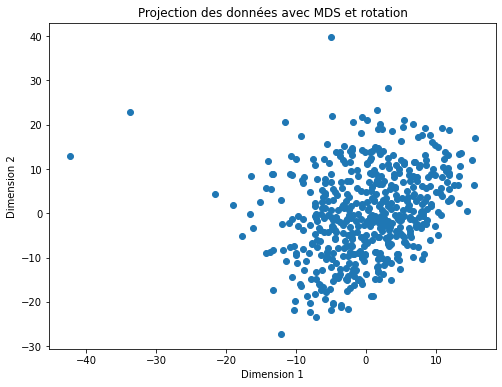

In [26]:
theta = 80 * np.pi / 180.  # Angle de rotation en radians
rot = np.array([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])  # Matrice de rotation 2D

Xr = np.dot(X[:, :2], rot)  # Appliquer la rotation aux deux premières dimensions

# Appliquer le retournement de l'axe x
Xr[:, 0] *= -1  # Inverser l'axe x

# Tracer les points
plt.figure(figsize=(8, 6))
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.title("Projection des données avec MDS et rotation")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Stress pour chaque valeur de k :  [14094103.278661167, 1979394.1446834402, 774808.9028700036, 317615.52365383453]


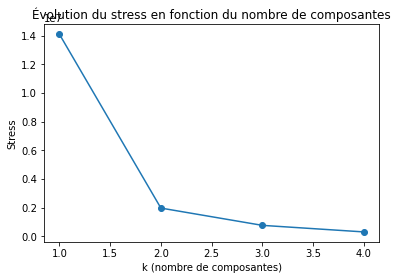

In [29]:
k_range = range(1, min(5, dissimilarity_matrix.shape[0]-1))  # Essayer k de 1 à min(5, nombre de points-1)

# 3. Calculer le stress pour chaque valeur de k
stress = [MDS(dissimilarity='precomputed', n_components=k,
              random_state=42, max_iter=300, eps=1e-9).fit(dissimilarity_matrix).stress_ for k in k_range]

# 4. Afficher les résultats
print("Stress pour chaque valeur de k : ", stress)

# 5. Tracer le stress en fonction de k
plt.plot(k_range, stress, marker='o')
plt.xlabel("k (nombre de composantes)")
plt.ylabel("Stress")
plt.title("Évolution du stress en fonction du nombre de composantes")
plt.show()

## ISOMAP

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets
X, color = datasets.make_s_curve(1000, random_state=42)

In [ ]:
isomap = manifold.Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X)

## TSNE

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

In [ ]:
 fig = plt.figure(figsize=(15, 5))
 plt.suptitle("Manifold Learning", fontsize=14)
 ax = fig.add_subplot(131, projection='3d')
 ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
 ax.view_init(4,-72)
 plt.title('2D "S shape" manifold in 3D')
 ax = fig.add_subplot(132)
 plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=color, cmap=plt.cm.Spectral)
 plt.title("Isomap")
 plt.xlabel("First component")
 plt.ylabel("Second component")
 ax = fig.add_subplot(133)
 plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
 plt.title("t-SNE")
 plt.xlabel("First component")
 plt.ylabel("Second component")
 plt.axis('tight')